# WBC Goal-Cutoff Sanity Check

This notebook computes task-level `dice@5` and true cap-hit rate for WBC using
`random_vs_uncertainty_v2 / pretrained_baseline / policy=random`, then compares
against the family goal from `experiments/baselines.json`.

In [16]:
from pathlib import Path
import json
import pandas as pd
import sys

# Ensure repo and vendored deps are on path
repo_root = Path("/data/ddmg/mvseg-ordering/")
for path in [repo_root, repo_root / "UniverSeg", repo_root / "MultiverSeg"]:
    if str(path) not in sys.path:
        sys.path.append(str(path))
from experiments.analysis.planb_utils import iter_planb_subset_dirs

procedure = 'random_vs_uncertainty_v2'
ablation = 'pretrained_baseline'
policy = 'random'
dataset = 'WBC'
iteration_k = 5

with open(repo_root / 'experiments' / 'baselines.json', 'r', encoding='utf-8') as f:
    goal = float(json.load(f)[dataset])

print(f'{dataset} goal cutoff from baselines.json: {goal:.6f}')

WBC goal cutoff from baselines.json: 0.954811


In [17]:
entries = list(iter_planb_subset_dirs(
    repo_root=repo_root,
    procedure=procedure,
    ablation=ablation,
    policy=policy,
    include_families=[dataset],
))

rows = []
for meta in entries:
    subset_dir = Path(meta['subset_dir'])
    subset_idx = int(meta['subset_index'])
    task_id = str(meta['task_id'])

    iter_csv = subset_dir / 'results' / 'support_images_iterations.csv'
    summary_csv = subset_dir / 'results' / 'support_images_summary.csv'

    if not iter_csv.exists() or not summary_csv.exists():
        continue

    iter_df = pd.read_csv(iter_csv)
    summary_df = pd.read_csv(summary_csv)

    iter_k_df = iter_df[iter_df['iteration'] == iteration_k]
    dice_at_k = float(iter_k_df['score'].mean()) if len(iter_k_df) else float('nan')

    reached_cutoff = summary_df['reached_cutoff'].astype(str).str.lower().isin(['true', '1', 't', 'yes'])
    at_cap = (summary_df['iterations_used'] >= summary_df['prompt_limit']) & (~reached_cutoff)

    rows.append({
        'task_id': task_id,
        'subset_index': subset_idx,
        f'dice_at_{iteration_k}': dice_at_k,
        'cap_hit_rate': float(at_cap.mean()),
    })

subset_df = pd.DataFrame(rows)
subset_df

,task_id,subset_index,dice_at_5,cap_hit_rate
0,WBC/WBC_CV_EM_0_label0_maxslice_idx638,0,0.942850,0.241
1,WBC/WBC_CV_EM_0_label0_maxslice_idx638,1,0.931504,0.298
2,WBC/WBC_CV_EM_0_label0_maxslice_idx638,2,0.919863,0.502
3,WBC/WBC_CV_EM_0_label0_maxslice_idx638,3,0.940454,0.224
4,WBC/WBC_CV_EM_0_label0_maxslice_idx638,4,0.939188,0.211
...,...,...,...,...
75,WBC/WBC_JTSC_EM_0_label1_midslice_idx15,5,0.974371,0.000
76,WBC/WBC_JTSC_EM_0_label1_midslice_idx15,6,0.971052,0.002
77,WBC/WBC_JTSC_EM_0_label1_midslice_idx15,7,0.974751,0.000
78,WBC/WBC_JTSC_EM_0_label1_midslice_idx15,8,0.975988,0.000


In [18]:
task_df = (
    subset_df.groupby('task_id', as_index=False)
    .agg(
        n_subsets=('subset_index', 'nunique'),
        **{f'dice_at_{iteration_k}': (f'dice_at_{iteration_k}', 'mean')},
        cap_hit_rate=('cap_hit_rate', 'mean'),
    )
)
task_df['goal'] = goal
task_df['dice_minus_goal'] = task_df[f'dice_at_{iteration_k}'] - goal

task_df.sort_values(f'dice_at_{iteration_k}').reset_index(drop=True)

,task_id,n_subsets,dice_at_5,cap_hit_rate,goal,dice_minus_goal
0,WBC/WBC_CV_EM_0_label0_maxslice_idx638,10,0.929055,0.3375,0.954811,-0.025756
1,WBC/WBC_CV_EM_0_label0_midslice_idx12,10,0.929055,0.3375,0.954811,-0.025756
2,WBC/WBC_JTSC_EM_0_label0_midslice_idx14,10,0.940842,0.2249,0.954811,-0.013969
3,WBC/WBC_JTSC_EM_0_label0_maxslice_idx636,10,0.940842,0.2249,0.954811,-0.013969
4,WBC/WBC_JTSC_EM_0_label1_maxslice_idx637,10,0.973490,0.0008,0.954811,0.018679
5,WBC/WBC_JTSC_EM_0_label1_midslice_idx15,10,0.973490,0.0008,0.954811,0.018679
6,WBC/WBC_CV_EM_0_label1_midslice_idx13,10,0.980949,0.0000,0.954811,0.026138
7,WBC/WBC_CV_EM_0_label1_maxslice_idx639,10,0.980949,0.0000,0.954811,0.026138


In [19]:
summary = task_df[[f'dice_at_{iteration_k}', 'cap_hit_rate', 'dice_minus_goal']].describe()
corr = task_df[['dice_minus_goal', 'cap_hit_rate']].corr().iloc[0, 1]

display(summary)
print(f'Correlation(dice_minus_goal, cap_hit_rate) = {corr:.4f}')

,dice_at_5,cap_hit_rate,dice_minus_goal
count,8.000000,8.000000,8.000000
mean,0.956084,0.140800,0.001273
std,0.023202,0.156011,0.023202
min,0.929055,0.000000,-0.025756
25%,0.937895,0.000600,-0.016916
50%,0.957166,0.112850,0.002355
75%,0.975355,0.253050,0.020544
max,0.980949,0.337500,0.026138


Correlation(dice_minus_goal, cap_hit_rate) = -0.9895


No updates to index
Filtered task_df: 1248
got task df: 1248


/data/ddmg/mvseg-ordering/experiments/dataset/multisegment2d.py:156: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["label_type"].fillna("soft", inplace=True)


target_datasets: 1248
torch.Size([1, 128, 128])


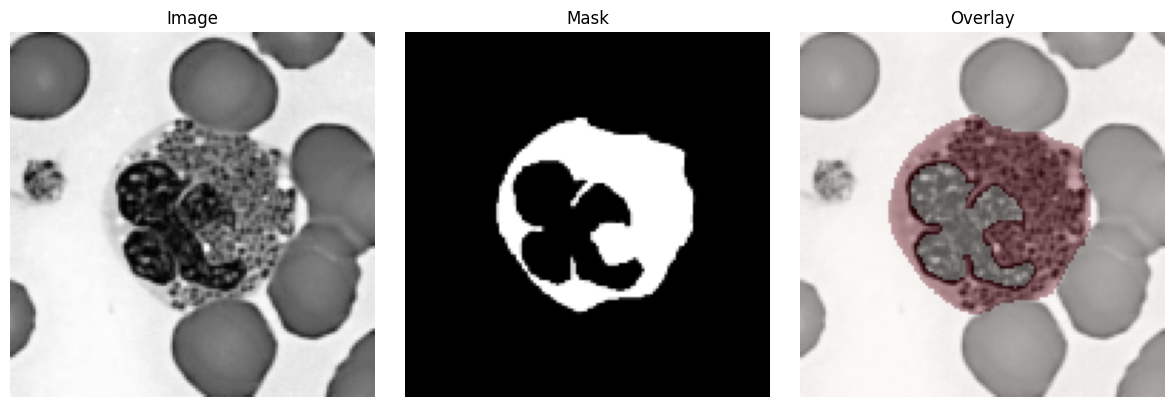

In [23]:
from experiments.dataset.mega_medical_dataset import MegaMedicalDataset
ds = MegaMedicalDataset(dataset_target=638, split='train', seed=23)
img, seg = ds.get_item_by_data_index(0)
print(img.shape)

import numpy as np
import torch
import matplotlib.pyplot as plt

def to_numpy_hw(x):
    if isinstance(x, torch.Tensor):
        x = x.detach().cpu().numpy()
    x = np.asarray(x)

    # Common shapes: [1,H,W], [H,W], [C,H,W], [H,W,1]
    if x.ndim == 3:
        if x.shape[0] == 1:      # [1,H,W]
            x = x.squeeze(0)
        elif x.shape[-1] == 1:   # [H,W,1]
            x = x[..., 0]
        elif x.shape[0] == 3:    # [3,H,W] -> [H,W,3]
            x = np.moveaxis(x, 0, -1)
    return x

img, seg = ds.get_item_by_data_index(0)
img_np = to_numpy_hw(img)
seg_np = to_numpy_hw(seg)

fig, ax = plt.subplots(1, 3, figsize=(12, 4))
ax[0].imshow(img_np, cmap="gray")
ax[0].set_title("Image")
ax[0].axis("off")

ax[1].imshow(seg_np, cmap="gray")
ax[1].set_title("Mask")
ax[1].axis("off")

ax[2].imshow(img_np, cmap="gray")
ax[2].imshow(seg_np > 0, cmap="Reds", alpha=0.35)
ax[2].set_title("Overlay")
ax[2].axis("off")

plt.tight_layout()

